# Exploring batch size effects on Chromebook 2

We explore effects of varying the batch size on **performance** of inference:

- of 4 different CNN **models** (net architecture + weights):
  - [AlexNet](https://github.com/BVLC/caffe/tree/master/models/bvlc_alexnet);
  - [SqueezeNet 1.0](https://github.com/DeepScale/SqueezeNet/tree/master/SqueezeNet_v1.0);
  - [SqueezeNet 1.1](https://github.com/DeepScale/SqueezeNet/tree/master/SqueezeNet_v1.1);
  - [GoogleNet](https://github.com/BVLC/caffe/tree/master/models/bvlc_googlenet);

- with 4 different **libraries**:

  - [CPU] [OpenBLAS](https://github.com/xianyi/OpenBLAS) 0.2.18;
  - [GPU] [clBLAS](https://github.com/clMathLibraries/clBLAS) 2.4;
  - [GPU] [CLBlast](https://github.com/CNugteren/CLBlast) dev (35623cd > 0.8.0);
  - [GPU] [CLBlast](https://github.com/CNugteren/CLBlast) dev (35623cd > 0.8.0) with Mali-optimized [overlay](https://github.com/intelfx/CLBlast/tree/mali-overlay) (641bb07);
  
- on the [Samsung Chromebook 2](http://www.samsung.com/us/computing/chromebooks/under-12/samsung-chromebook-2-11-6-xe503c12-k01us/) **platform**:
  - [CPU] quad-core ARM Cortex-A15 (@ 1900 MHz);
  - [GPU] quad-core ARM Mali-T628 (@ 600 MHz);
  - [GPU] OpenCL driver 6.0 (r6p0);
  - [GPU] OpenCL standard 1.1;
  - [RAM] 2 GB;
  - Gentoo Linux [over](community.arm.com/groups/arm-mali-graphics/blog/2014/12/18/installing-opencl-on-chromebook-2-in-30-minutes) ChromeOS with `/etc/lsb-release`:
```
CHROMEOS_AUSERVER=https://tools.google.com/service/update2
CHROMEOS_BOARD_APPID={24E2E4F7-F92C-6115-3E26-02C7EAA02946}
CHROMEOS_CANARY_APPID={90F229CE-83E2-4FAF-8479-E368A34938B1}
CHROMEOS_DEVSERVER=
CHROMEOS_RELEASE_APPID={24E2E4F7-F92C-6115-3E26-02C7EAA02946}
CHROMEOS_RELEASE_BOARD=peach_pit-signed-mp-v2keys
CHROMEOS_RELEASE_BRANCH_NUMBER=68
CHROMEOS_RELEASE_BUILD_NUMBER=8350
CHROMEOS_RELEASE_BUILD_TYPE=Official Build
CHROMEOS_RELEASE_CHROME_MILESTONE=52
CHROMEOS_RELEASE_DESCRIPTION=8350.68.0 (Official Build) stable-channel peach_pit 
CHROMEOS_RELEASE_NAME=Chrome OS
CHROMEOS_RELEASE_PATCH_NUMBER=0
CHROMEOS_RELEASE_TRACK=stable-channel
CHROMEOS_RELEASE_VERSION=8350.68.0
DEVICETYPE=CHROMEBOOK
GOOGLE_RELEASE=8350.68.0
```

## Includes

### Collective Knowledge

In [1]:
import ck.kernel as ck
print ('CK version: %s' % ck.__version__)

CK version: 1.7.4dev


### Scientific

In [2]:
import math
import IPython as ip
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib as mp
import matplotlib.pyplot as plt

In [3]:
print ('IPython version: %s' % ip.__version__)
print ('NumPy version: %s' % np.__version__)
print ('SciPy version: %s' % sp.__version__)
print ('Pandas version: %s' % pd.__version__)
print ('Matplotlib version: %s' % mp.__version__)

IPython version: 4.1.1
NumPy version: 1.10.4
SciPy version: 0.17.0
Pandas version: 0.18.0+57.g101d81d.dirty
Matplotlib version: 1.5.1


In [4]:
from IPython.display import display
from matplotlib import cm
%matplotlib inline

## Access experimental results

In [5]:
def search_experimental_points_by_tags(tags):
    r=ck.access({'action':'get', 'module_uoa':'experiment', 'tags':tags, 'load_json_files':['0001']})
    if r['return']>0:
        print ("Error: %s" % r['error'])
        exit(1)
    # FIXME: For now, assume a single entry per the given tags.
    results = {}
    for point in r['points']:
            point_data_raw = point['0001']
            point_data_dict = {}
            time_fw_ms = [
                characteristics['run']['time_fw_ms'] 
                for characteristics in point_data_raw['characteristics_list']
                if characteristics['run']['run_success'] == 'yes'
            ]
            batch_size = point_data_raw['choices']['env']['CK_CAFFE_BATCH_SIZE']
            results[batch_size] = time_fw_ms
    return results

## Analyze experimental results

In [6]:
def analyze(results):
    df = pd.DataFrame(data=results)
    df.columns.name = 'Batch size'
    df.index.name='Repetition'

    # Show raw results.
    print ('Experimental results: raw')
    display(df)

    df_stats = df.describe()
    df_stats.loc['mean per image'] = df_stats.ix['mean'] / df.columns
    df_stats.loc['std per image']  =  df_stats.ix['std'] / df.columns # FIXME: div by sqrt(n)?
    
    # Show stats.
    print ('Experimental results: stats')
    display(df_stats)

    # Show two plots side-by-side: mean time per batch and mean time per image.
    fig, axs = plt.subplots(1,2)
    df_stats.ix['mean'] \
        .plot(ax=axs[0],
            yerr=df_stats.ix['std'],
            title='Mean time per batch (ms)',
            kind='bar', grid=True, rot=0, figsize=[10, 4], colormap=cm.autumn_r
        )
    df_stats.ix['mean per image'] \
        .plot(ax=axs[1],
            yerr=df_stats.ix['std per image'],
            title='Mean time per image (ms)',
            kind='bar', grid=True, rot=0, figsize=[10, 4], colormap=cm.autumn
        )
    
    # Show batch size giving minimum time per image, mean and std.
    min_time_per_image_idx = df_stats.ix['mean per image'].idxmin()
    if not math.isnan(min_time_per_image_idx):
        print (
            'Minimum time per image: batch size = %d, mean = %.2f, std = %.2f' % (
                min_time_per_image_idx, 
                df_stats.ix['mean per image'][min_time_per_image_idx],
                df_stats.ix['std per image'][min_time_per_image_idx]
            )
        )
    else:
        print ('Minimum time per image: N/A')

### AlexNet

#### AlexNet / clBLAS

Experimental results: raw


Batch size,1,2,3,4
Repetition,,,,
0,565.242,1099.58,1617.11,2378.96
1,561.106,1076.68,1621.44,2294.17
2,531.255,1111.17,1577.70,2390.76


Experimental results: stats


Batch size,1,2,3,4
count,3.000000,3.000000,3.000000,3.000000
mean,552.534333,1095.810000,1605.416667,2354.630000
std,18.544113,17.551345,24.100777,52.691258
min,531.255000,1076.680000,1577.700000,2294.170000
25%,546.180500,1088.130000,1597.405000,2336.565000
50%,561.106000,1099.580000,1617.110000,2378.960000
75%,563.174000,1105.375000,1619.275000,2384.860000
max,565.242000,1111.170000,1621.440000,2390.760000
mean per image,552.534333,547.905000,535.138889,588.657500
std per image,18.544113,8.775672,8.033592,13.172815


Minimum time per image: batch size = 3, mean = 535.14, std = 8.03


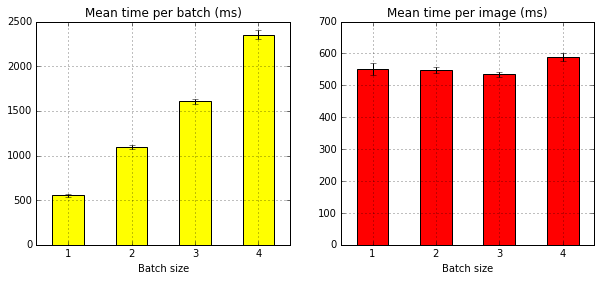

In [7]:
alexnet_clblas_tags = 'chromebook2,time,caffemodel,alexnet,clblas'
alexnet_clblas_results = search_experimental_points_by_tags(alexnet_clblas_tags)
analyze(alexnet_clblas_results)

#### AlexNet / CLBlast dev

Experimental results: raw


Batch size,1,2,3,4
Repetition,,,,
0,568.821,2136.33,2393.56,2689.57
1,560.323,2131.77,2390.96,2687.91
2,566.146,2134.72,2396.83,2695.28


Experimental results: stats


Batch size,1,2,3,4
count,3.000000,3.000000,3.000000,3.000000
mean,565.096667,2134.273333,2393.783333,2690.920000
std,4.345092,2.312582,2.941366,3.866019
min,560.323000,2131.770000,2390.960000,2687.910000
25%,563.234500,2133.245000,2392.260000,2688.740000
50%,566.146000,2134.720000,2393.560000,2689.570000
75%,567.483500,2135.525000,2395.195000,2692.425000
max,568.821000,2136.330000,2396.830000,2695.280000
mean per image,565.096667,1067.136667,797.927778,672.730000
std per image,4.345092,1.156291,0.980455,0.966505


Minimum time per image: batch size = 1, mean = 565.10, std = 4.35


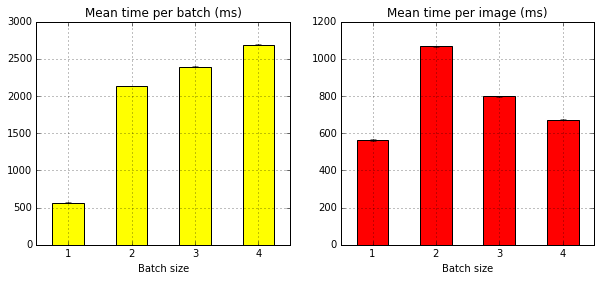

In [8]:
alexnet_clblast_development_tags = 'chromebook2,time,caffemodel,alexnet,clblast,vdevelopment'
alexnet_clblast_development_results = search_experimental_points_by_tags(alexnet_clblast_development_tags)
analyze(alexnet_clblast_development_results)

#### AlexNet / CLBlast with Mali-optimized overlay

Experimental results: raw


Batch size,1,2,3,4
Repetition,,,,
0,484.194,2797.65,2398.14,2615.90
1,467.265,2127.75,2290.31,2477.50
2,508.266,2098.55,2282.12,2489.39


Experimental results: stats


Batch size,1,2,3,4
count,3.000000,3.000000,3.000000,3.000000
mean,486.575000,2341.316667,2323.523333,2527.596667
std,20.603941,395.465856,64.749550,76.703664
min,467.265000,2098.550000,2282.120000,2477.500000
25%,475.729500,2113.150000,2286.215000,2483.445000
50%,484.194000,2127.750000,2290.310000,2489.390000
75%,496.230000,2462.700000,2344.225000,2552.645000
max,508.266000,2797.650000,2398.140000,2615.900000
mean per image,486.575000,1170.658333,774.507778,631.899167
std per image,20.603941,197.732928,21.583183,19.175916


Minimum time per image: batch size = 1, mean = 486.58, std = 20.60


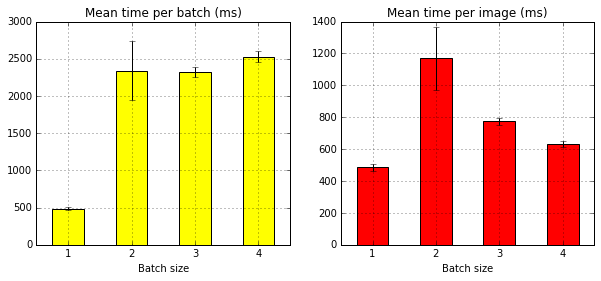

In [9]:
alexnet_clblast_mali_overlay_tags = 'chromebook2,time,caffemodel,alexnet,clblast,vmali-overlay'
alexnet_clblast_mali_overlay_results = search_experimental_points_by_tags(alexnet_clblast_mali_overlay_tags)
analyze(alexnet_clblast_mali_overlay_results)

#### AlexNet / OpenBLAS

Experimental results: raw


Batch size,1,2,3,4
Repetition,,,,
0,542.903,802.774,1137.20,1207.36
1,689.488,976.314,1020.15,1348.32
2,595.458,1494.250,1055.80,1405.32


Experimental results: stats


Batch size,1,2,3,4
count,3.000000,3.000000,3.000000,3.000000
mean,609.283000,1091.112667,1071.050000,1320.333333
std,74.263979,359.748266,59.996646,101.904271
min,542.903000,802.774000,1020.150000,1207.360000
25%,569.180500,889.544000,1037.975000,1277.840000
50%,595.458000,976.314000,1055.800000,1348.320000
75%,642.473000,1235.282000,1096.500000,1376.820000
max,689.488000,1494.250000,1137.200000,1405.320000
mean per image,609.283000,545.556333,357.016667,330.083333
std per image,74.263979,179.874133,19.998882,25.476068


Minimum time per image: batch size = 4, mean = 330.08, std = 25.48


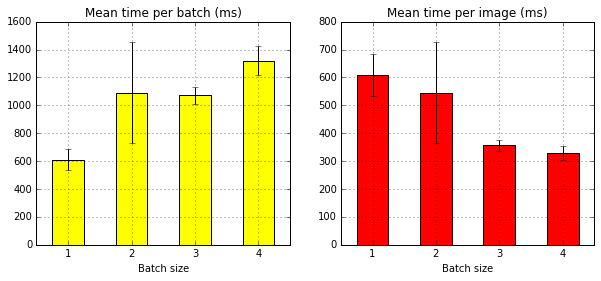

In [10]:
alexnet_openblas_tags = 'chromebook2,time,caffemodel,alexnet,openblas'
alexnet_openblas_results = search_experimental_points_by_tags(alexnet_openblas_tags)
analyze(alexnet_openblas_results)

### SqueezeNet 1.0

#### SqueezeNet 1.0 / clBLAS

Experimental results: raw


Batch size,1,2,3,4
Repetition,,,,
0,708.721,1429.66,2012.97,2660.97
1,714.289,1386.06,2049.74,2654.21
2,759.288,1320.15,1977.08,2669.93


Experimental results: stats


Batch size,1,2,3,4
count,3.000000,3.000000,3.000000,3.000000
mean,727.432667,1378.623333,2013.263333,2661.703333
std,27.727646,55.132459,36.330888,7.885616
min,708.721000,1320.150000,1977.080000,2654.210000
25%,711.505000,1353.105000,1995.025000,2657.590000
50%,714.289000,1386.060000,2012.970000,2660.970000
75%,736.788500,1407.860000,2031.355000,2665.450000
max,759.288000,1429.660000,2049.740000,2669.930000
mean per image,727.432667,689.311667,671.087778,665.425833
std per image,27.727646,27.566229,12.110296,1.971404


Minimum time per image: batch size = 4, mean = 665.43, std = 1.97


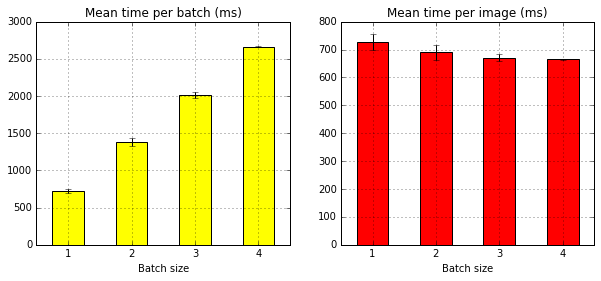

In [11]:
squeezenet_1_0_clblas_tags = 'chromebook2,time,caffemodel,squeezenet-1.0,clblas'
squeezenet_1_0_clblas_results = search_experimental_points_by_tags(squeezenet_1_0_clblas_tags)
analyze(squeezenet_1_0_clblas_results)

#### SqueezeNet 1.0 / CLBlast dev

Experimental results: raw


Batch size,1,2,3,4
Repetition,,,,
0,682.928,1307.86,1961.00,2485.74
1,683.398,1307.47,1902.75,2490.64
2,685.782,1293.84,1918.97,2439.18


Experimental results: stats


Batch size,1,2,3,4
count,3.000000,3.000000,3.000000,3.000000
mean,684.036000,1303.056667,1927.573333,2471.853333
std,1.530233,7.984249,30.062911,28.401805
min,682.928000,1293.840000,1902.750000,2439.180000
25%,683.163000,1300.655000,1910.860000,2462.460000
50%,683.398000,1307.470000,1918.970000,2485.740000
75%,684.590000,1307.665000,1939.985000,2488.190000
max,685.782000,1307.860000,1961.000000,2490.640000
mean per image,684.036000,651.528333,642.524444,617.963333
std per image,1.530233,3.992125,10.020970,7.100451


Minimum time per image: batch size = 4, mean = 617.96, std = 7.10


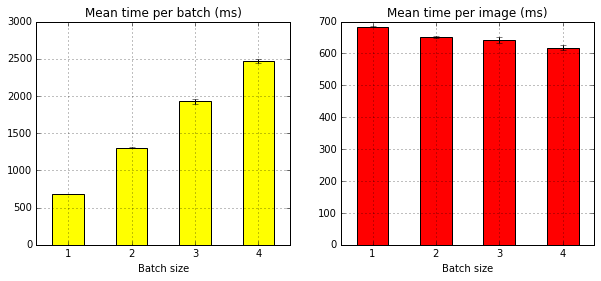

In [12]:
squeezenet_1_0_clblast_development_tags = 'chromebook2,time,caffemodel,squeezenet-1.0,clblast,vdevelopment'
squeezenet_1_0_clblast_development_results = search_experimental_points_by_tags(squeezenet_1_0_clblast_development_tags)
analyze(squeezenet_1_0_clblast_development_results)

#### SqueezeNet 1.0 / CLBlast dev with Mali-optimized overlay

Experimental results: raw


Batch size,1,2,3,4
Repetition,,,,
0,607.458,1000.66,1417.07,2114.95
1,537.179,1018.38,1434.45,1981.16
2,536.209,1026.75,1643.50,2057.11


Experimental results: stats


Batch size,1,2,3,4
count,3.000000,3.000000,3.000000,3.000000
mean,560.282000,1015.263333,1498.340000,2051.073333
std,40.858493,13.321307,126.012243,67.098972
min,536.209000,1000.660000,1417.070000,1981.160000
25%,536.694000,1009.520000,1425.760000,2019.135000
50%,537.179000,1018.380000,1434.450000,2057.110000
75%,572.318500,1022.565000,1538.975000,2086.030000
max,607.458000,1026.750000,1643.500000,2114.950000
mean per image,560.282000,507.631667,499.446667,512.768333
std per image,40.858493,6.660654,42.004081,16.774743


Minimum time per image: batch size = 3, mean = 499.45, std = 42.00


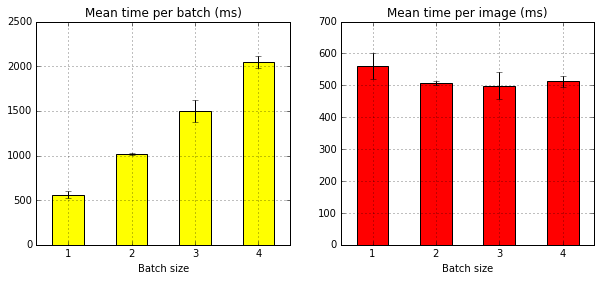

In [13]:
squeezenet_1_0_clblast_mali_overlay_tags = 'chromebook2,time,caffemodel,squeezenet-1.0,clblast,vmali-overlay'
squeezenet_1_0_clblast_mali_overlay_results = search_experimental_points_by_tags(squeezenet_1_0_clblast_mali_overlay_tags)
analyze(squeezenet_1_0_clblast_mali_overlay_results)

#### SqueezeNet 1.0 / OpenBLAS

Experimental results: raw


Batch size,1,2,3,4
Repetition,,,,
0,261.860,587.635,922.405,1065.95
1,255.623,607.143,930.073,1218.85
2,387.804,648.517,786.573,1016.12


Experimental results: stats


Batch size,1,2,3,4
count,3.000000,3.000000,3.000000,3.000000
mean,301.762333,614.431667,879.683667,1100.306667
std,74.579497,31.088551,80.727299,105.641605
min,255.623000,587.635000,786.573000,1016.120000
25%,258.741500,597.389000,854.489000,1041.035000
50%,261.860000,607.143000,922.405000,1065.950000
75%,324.832000,627.830000,926.239000,1142.400000
max,387.804000,648.517000,930.073000,1218.850000
mean per image,301.762333,307.215833,293.227889,275.076667
std per image,74.579497,15.544275,26.909100,26.410401


Minimum time per image: batch size = 4, mean = 275.08, std = 26.41


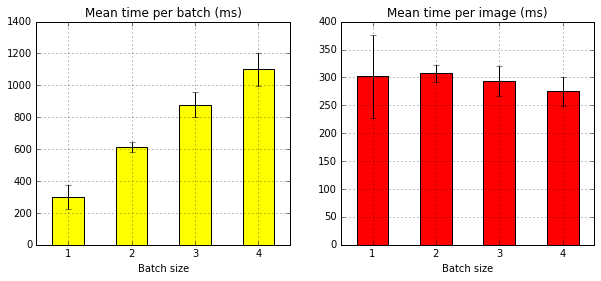

In [14]:
squeezenet_1_0_openblas_tags = 'chromebook2,time,caffemodel,squeezenet-1.0,openblas'
squeezenet_1_0_openblas_results = search_experimental_points_by_tags(squeezenet_1_0_openblas_tags)
analyze(squeezenet_1_0_openblas_results)

### SqueezeNet 1.1

#### SqueezeNet 1.1 / clBLAS

Experimental results: raw


Batch size,1,2,3,4
Repetition,,,,
0,358.422,529.918,751.533,965.377
1,308.110,532.156,752.198,963.677
2,310.558,535.097,753.590,970.990


Experimental results: stats


Batch size,1,2,3,4
count,3.000000,3.000000,3.000000,3.000000
mean,325.696667,532.390333,752.440333,966.681333
std,28.367389,2.597440,1.049693,3.827004
min,308.110000,529.918000,751.533000,963.677000
25%,309.334000,531.037000,751.865500,964.527000
50%,310.558000,532.156000,752.198000,965.377000
75%,334.490000,533.626500,752.894000,968.183500
max,358.422000,535.097000,753.590000,970.990000
mean per image,325.696667,266.195167,250.813444,241.670333
std per image,28.367389,1.298720,0.349898,0.956751


Minimum time per image: batch size = 4, mean = 241.67, std = 0.96


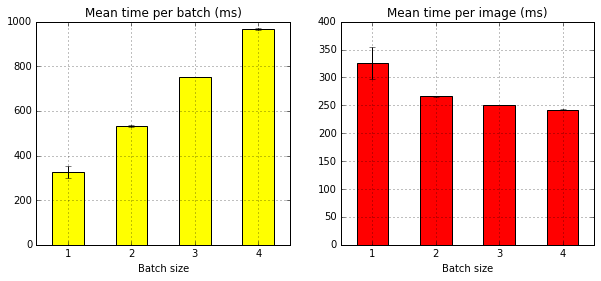

In [15]:
squeezenet_1_1_clblas_tags = 'chromebook2,time,caffemodel,squeezenet-1.1,clblas'
squeezenet_1_1_clblas_results = search_experimental_points_by_tags(squeezenet_1_1_clblas_tags)
analyze(squeezenet_1_1_clblas_results)

#### SqueezeNet 1.1 / CLBlast dev

Experimental results: raw


Batch size,1,2,3,4
Repetition,,,,
0,517.461,819.343,1197.68,1602.55
1,543.982,828.103,1223.11,1553.30
2,458.714,978.645,1212.22,1592.05


Experimental results: stats


Batch size,1,2,3,4
count,3.00000,3.000000,3.000000,3.000000
mean,506.71900,875.363667,1211.003333,1582.633333
std,43.63715,89.551436,12.758583,25.940236
min,458.71400,819.343000,1197.680000,1553.300000
25%,488.08750,823.723000,1204.950000,1572.675000
50%,517.46100,828.103000,1212.220000,1592.050000
75%,530.72150,903.374000,1217.665000,1597.300000
max,543.98200,978.645000,1223.110000,1602.550000
mean per image,506.71900,437.681833,403.667778,395.658333
std per image,43.63715,44.775718,4.252861,6.485059


Minimum time per image: batch size = 4, mean = 395.66, std = 6.49


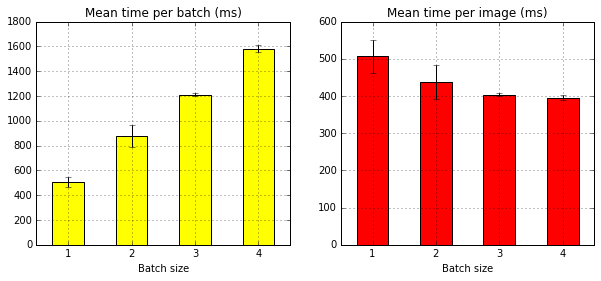

In [16]:
squeezenet_1_1_clblast_development_tags = 'chromebook2,time,caffemodel,squeezenet-1.1,clblast,vdevelopment'
squeezenet_1_1_clblast_development_results = search_experimental_points_by_tags(squeezenet_1_1_clblast_development_tags)
analyze(squeezenet_1_1_clblast_development_results)

#### SqueezeNet 1.1 / CLBlast dev with Mali-optimized overlay

In [17]:
squeezenet_1_1_clblast_mali_overlay_tags = 'chromebook2,time,caffemodel,squeezenet-1.1,clblast,vmali-overlay'
squeezenet_1_1_clblast_mali_overlay_results = search_experimental_points_by_tags(squeezenet_1_1_clblast_mali_overlay_tags)
# analyze(squeezenet_1_1_clblast_mali_overlay_results)

**NB:** Failures are being investigated.

#### SqueezeNet 1.1 / OpenBLAS

Experimental results: raw


Batch size,1,2,3,4
Repetition,,,,
0,136.650,283.784,475.356,574.729
1,217.693,289.290,425.667,555.904
2,225.273,276.657,413.146,546.859


Experimental results: stats


Batch size,1,2,3,4
count,3.000000,3.000000,3.000000,3.00000
mean,193.205333,283.243667,438.056333,559.16400
std,49.124774,6.333809,32.903536,14.21812
min,136.650000,276.657000,413.146000,546.85900
25%,177.171500,280.220500,419.406500,551.38150
50%,217.693000,283.784000,425.667000,555.90400
75%,221.483000,286.537000,450.511500,565.31650
max,225.273000,289.290000,475.356000,574.72900
mean per image,193.205333,141.621833,146.018778,139.79100
std per image,49.124774,3.166905,10.967845,3.55453


Minimum time per image: batch size = 4, mean = 139.79, std = 3.55


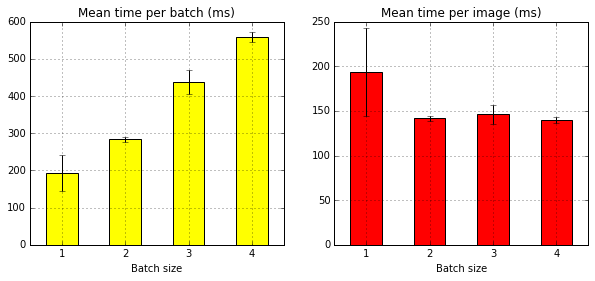

In [18]:
squeezenet_1_1_openblas_tags = 'chromebook2,time,caffemodel,squeezenet-1.1,openblas'
squeezenet_1_1_openblas_results = search_experimental_points_by_tags(squeezenet_1_1_openblas_tags)
analyze(squeezenet_1_1_openblas_results)

### GoogleNet

#### GoogleNet / clBLAS

Experimental results: raw


Batch size,1,2,3,4
Repetition,,,,
0,999.882,1788.46,2590.40,3378.85
1,999.157,1802.06,2568.09,3335.89
2,953.876,1781.46,2602.13,3327.64


Experimental results: stats


Batch size,1,2,3,4
count,3.00000,3.000000,3.000000,3.000000
mean,984.30500,1790.660000,2586.873333,3347.460000
std,26.35478,10.474732,17.291860,27.495721
min,953.87600,1781.460000,2568.090000,3327.640000
25%,976.51650,1784.960000,2579.245000,3331.765000
50%,999.15700,1788.460000,2590.400000,3335.890000
75%,999.51950,1795.260000,2596.265000,3357.370000
max,999.88200,1802.060000,2602.130000,3378.850000
mean per image,984.30500,895.330000,862.291111,836.865000
std per image,26.35478,5.237366,5.763953,6.873930


Minimum time per image: batch size = 4, mean = 836.86, std = 6.87


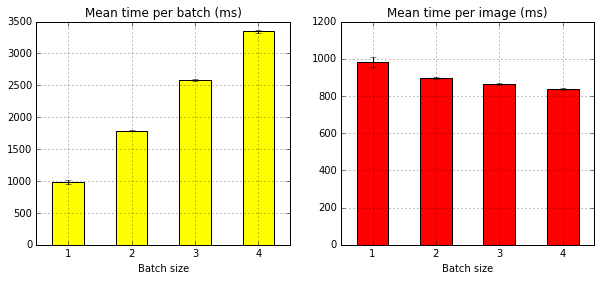

In [19]:
googlenet_clblas_tags = 'chromebook2,time,caffemodel,googlenet,clblas'
googlenet_clblas_results = search_experimental_points_by_tags(googlenet_clblas_tags)
analyze(googlenet_clblas_results)

#### GoogleNet / CLBlast dev

Experimental results: raw


Batch size,1,2,3,4
Repetition,,,,
0,1207.05,2395.89,3509.58,4431.53
1,1338.20,2398.48,3357.00,4321.79
2,1227.45,2417.00,3381.19,4515.95


Experimental results: stats


Batch size,1,2,3,4
count,3.000000,3.000000,3.000000,3.000000
mean,1257.566667,2403.790000,3415.923333,4423.090000
std,70.571530,11.513258,82.005899,97.354772
min,1207.050000,2395.890000,3357.000000,4321.790000
25%,1217.250000,2397.185000,3369.095000,4376.660000
50%,1227.450000,2398.480000,3381.190000,4431.530000
75%,1282.825000,2407.740000,3445.385000,4473.740000
max,1338.200000,2417.000000,3509.580000,4515.950000
mean per image,1257.566667,1201.895000,1138.641111,1105.772500
std per image,70.571530,5.756629,27.335300,24.338693


Minimum time per image: batch size = 4, mean = 1105.77, std = 24.34


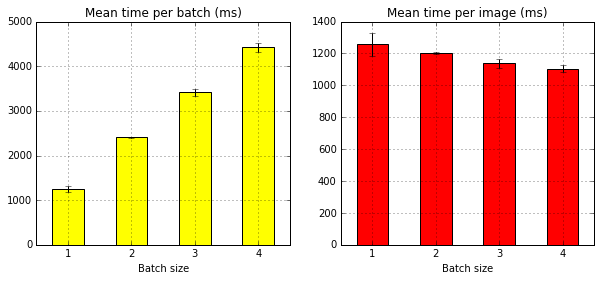

In [20]:
googlenet_clblast_development_tags = 'chromebook2,time,caffemodel,googlenet,clblast,vdevelopment'
googlenet_clblast_development_results = search_experimental_points_by_tags(googlenet_clblast_development_tags)
analyze(googlenet_clblast_development_results)

#### GoogleNet / CLBlast dev with Mali-optimized overlay

In [21]:
googlenet_clblast_mali_overlay_tags = 'chromebook2,time,caffemodel,googlenet,clblast,vmali-overlay'
googlenet_clblast_mali_overlay_results = search_experimental_points_by_tags(googlenet_clblast_mali_overlay_tags)
# analyze(googlenet_clblast_mali_overlay_results)

**NB:** Failures are being investigated.

#### GoogleNet / OpenBLAS

Experimental results: raw


Batch size,1,2,3,4
Repetition,,,,
0,642.151,1837.60,2323.35,2457.15
1,765.678,1114.54,2472.54,2809.89
2,643.057,1524.18,1981.70,2565.39


Experimental results: stats


Batch size,1,2,3,4
count,3.000000,3.000000,3.000000,3.000000
mean,683.628667,1492.106667,2259.196667,2610.810000
std,71.058251,362.595456,251.630114,180.703097
min,642.151000,1114.540000,1981.700000,2457.150000
25%,642.604000,1319.360000,2152.525000,2511.270000
50%,643.057000,1524.180000,2323.350000,2565.390000
75%,704.367500,1680.890000,2397.945000,2687.640000
max,765.678000,1837.600000,2472.540000,2809.890000
mean per image,683.628667,746.053333,753.065556,652.702500
std per image,71.058251,181.297728,83.876705,45.175774


Minimum time per image: batch size = 4, mean = 652.70, std = 45.18


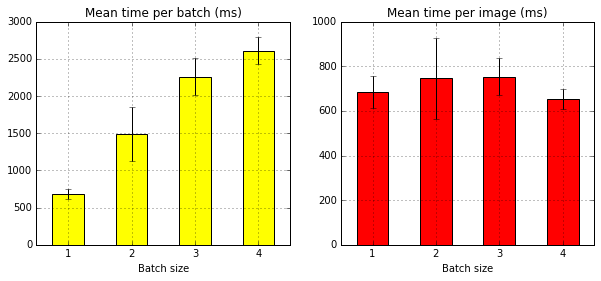

In [22]:
googlenet_openblas_tags = 'chromebook2,time,caffemodel,googlenet,openblas'
googlenet_openblas_results = search_experimental_points_by_tags(googlenet_openblas_tags)
analyze(googlenet_openblas_results)